**Импортирование**

In [325]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pickle
from sklearn.metrics import classification_report
from sklearn.datasets import make_circles, make_moons
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [326]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


*Часть 1*

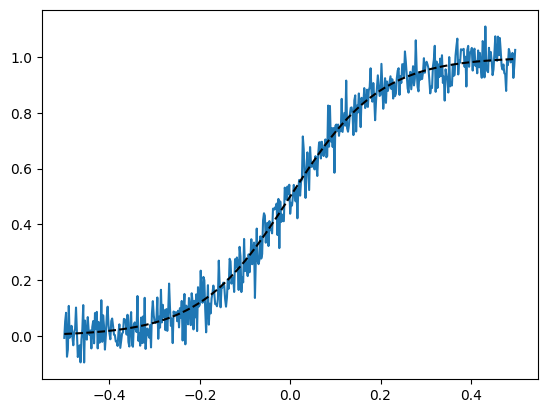

In [327]:
X = (np.arange(500)/500 - 0.5)
y = 1/(1+np.exp(-10*X))
yn = np.random.normal(scale=0.05, size=y.size)+y

plt.plot(X, yn)
plt.plot(X, y, linestyle='--', c='k')
################################################
tensor_X = torch.Tensor(X.reshape(-1, 1))
tensor_y = torch.Tensor(yn.reshape(-1, 1))

HIDDEN_SIZE = 64
# Инициализация весов MLP с одним скрытым слоём
weights_1 = (torch.rand(1, HIDDEN_SIZE)-.5)/10
bias_1 = torch.zeros(HIDDEN_SIZE)

weights_2 = (torch.rand(HIDDEN_SIZE, 1)-.5)/10
bias_2 = torch.zeros(1)

0.0026222162


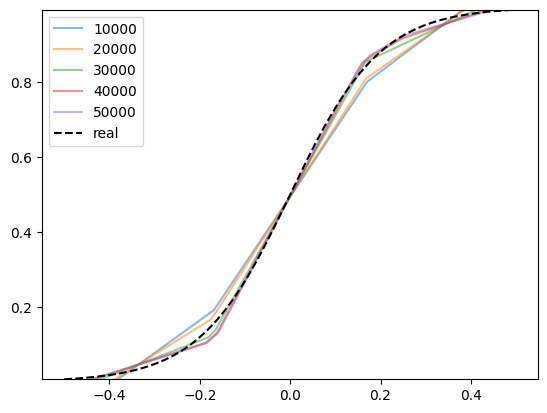

In [328]:
# Определяем функцию нелинейности
relu = lambda x: torch.maximum(x, torch.Tensor([0]))
# Прямой проход
forward = lambda x: (weights_2.t()*relu((weights_1*x) + bias_1)
                      ).sum(axis=-1,keepdims=True) + bias_2
loss = lambda y, y_: ((y-y_)**2).sum(axis=-1)

# # обратный проход
def backward(X, y, y_pred):
    # производная функции потерь по y_pred
    dL = 2*(y_pred-y)
    # значения нейронов скрытого слоя до применения активации
    Ax = (weights_1*X) + bias_1
    # значения нейронов скрытого слоя после применения активации
    A = relu(Ax)
    # производная функции потерь по weight_2
    dW2 = torch.mm(A.t(), dL)
    # производная функции потерь по bias_2
    db2 = dL.sum(axis=0)
    # производная функции потерь по значениям скрытого слоя после активации
    dA = torch.mm(dL, weights_2.t())
    # производная функции потерь по значениям скрытого слоя до активации
    dA[Ax<=0] = 0
    # производная функции потерь по weight_1
    dW = torch.mm(X.t(), dA)
    # производная функции потерь по bias_1
    db = dA.sum(axis=0)
    #print(dW.shape, db.shape, dW2.shape, db2.shape)
    return dW, db, dW2, db2

def optimize(params, grads, lr=0.001):
    # градиентный спуск по всей обучающей выборке
    W1, b1, W2, b2 = params
    W1 -= lr*grads[0]
    W2 -= lr*grads[2]
    b1 -= lr*grads[1]
    b2 -= lr*grads[3]
    return W1, b1, W2, b2

for i in range(50000): # 50 тысяч итераций градиентного спуска == 50 тысяч эпох
  output = forward(tensor_X)
  cur_loss = loss(output, tensor_y)
  grads = backward(tensor_X, tensor_y, output)
  params = [weights_1, bias_1, weights_2, bias_2]
  weights_1, bias_1, weights_2, bias_2 = optimize(params, grads, 1e-4)
  if (i+1)%10000 == 0:
      plt.plot(X, output.numpy(), label=str(i+1), alpha=0.5)
plt.plot(X, y, linestyle='--', c='k', label='real')
plt.legend()
plt.ylim(y.min(), y.max())
print(cur_loss.numpy().mean())

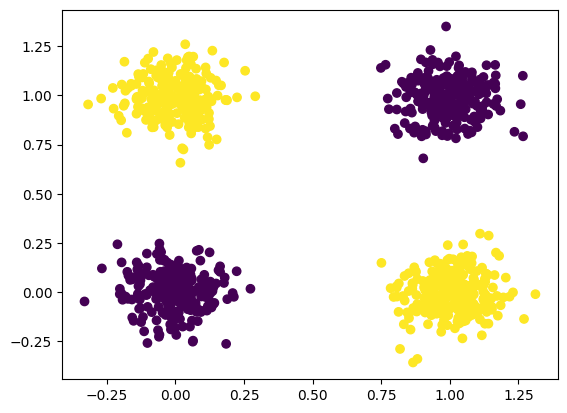

In [329]:
X = np.random.randint(2, size=(1000, 2))

y = (X[:, 0] + X[:, 1]) % 2 # XOR
X = X + np.random.normal(0, scale=0.1, size=X.shape)
#X, y = make_circles(n_samples=1000, noise=0.025)
#X, y = make_moons(n_samples=1000, noise=0.025)
plt.scatter(X[:, 0], X[:, 1], c=y)
####################################################
tensor_X = torch.Tensor(X.reshape(-1, 2))
tensor_y = torch.Tensor(y.reshape(-1, 1))

HIDDEN_SIZE = 16
# Инициализация весов MLP с одним скрытым слоём
weights_1 = ((torch.rand(2, HIDDEN_SIZE)-.5)/10).detach().requires_grad_(True)
bias_1 = torch.zeros(HIDDEN_SIZE, requires_grad=True)

weights_2 = ((torch.rand(HIDDEN_SIZE, 1)-.5)/10).detach().requires_grad_(True)
bias_2 = torch.zeros(1, requires_grad=True)

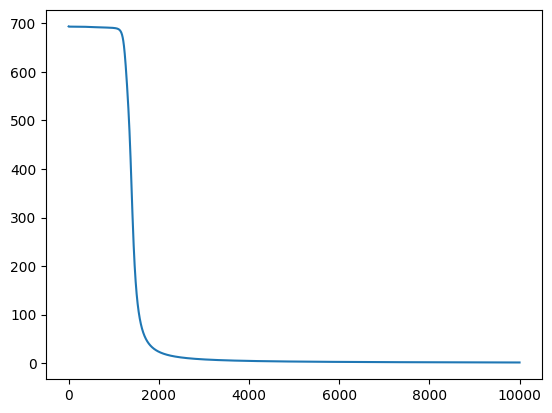

In [330]:
# Определяем функцию нелинейности
def sigmoid(x):
    return 1/(1+torch.exp(-x))

# Прямой проход
def forward(x):
    hidden = torch.mm(x, weights_1) + bias_1
    hidden_nonlin = sigmoid(hidden)
    output = (weights_2.t()*hidden_nonlin).sum(axis=-1,keepdims=True) + bias_2
    return sigmoid(output)
                       
# Logloss
def loss(y_true, y_pred):
    return -1*(y_true*torch.log(y_pred)+(1-y_true)*torch.log(1-y_pred)).sum()

# задаём шаг обучения
lr = 1e-3
# задаём число итераций
iters = 10000
params = [weights_1, bias_1, weights_2, bias_2]
losses = []
for i in range(iters):
    output = forward(tensor_X)
    lossval = loss(tensor_y, output)
    lossval.backward() # тут включается в работу autograd
    for w in params:
        with torch.no_grad():
            w -= w.grad*lr # обновляем веса
        w.grad.zero_() # зануляем градиенты, чтобы не накапливались за итерации
    losses.append(lossval.item())
# выводим историю функции потерь по итерациям
plt.plot(losses)

(-0.527864387688838, 1.5203671428051049)

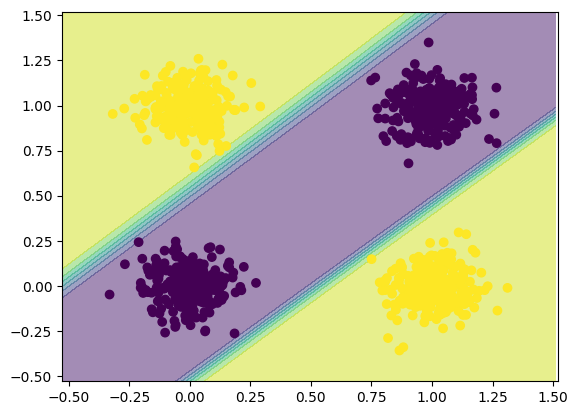

In [331]:
X_diff = X.max() - X.min()
X_left = X.min() - 0.1*X_diff
X_right = X.max() + 0.1*X_diff
grid = np.arange(X_left, X_right, 0.01)
grid_width = grid.size
surface = []
# создаем точки по сетке
for x1 in grid:
    for x2 in grid:
        surface.append((x1, x2))
surface = np.array(surface)
# получаем предсказания для всех точек
with torch.no_grad():
    Z = forward(torch.Tensor(surface)).detach().numpy()
# меняем форму в виде двухмерного массива
Z = Z.reshape(grid_width, grid_width)
xx = surface[:, 0].reshape(grid_width, grid_width)
yy = surface[:, 1].reshape(grid_width, grid_width)
# рисуем разделяющие поверхности классов
plt.contourf(xx, yy, Z, alpha=0.5)
# рисуем обучающую выборку
plt.scatter(X[:, 0], X[:, 1], c=output.detach().numpy()>0.5)
# задаём границы отображения графика
plt.xlim(X_left, X_right)
plt.ylim(X_left, X_right)

In [332]:
#!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
#!tar -xvzf cifar-100-python.tar.gz

Чтение тренировочной и тестовой выборки

[[[[255 255 255 ... 195 212 182]
   [255 254 254 ... 170 161 146]
   [255 254 255 ... 189 166 121]
   ...
   [148 142 140 ...  30  65  76]
   [122 120 126 ...  22  97 141]
   [ 87  88 101 ...  34 105 138]]

  [[255 255 255 ... 205 224 194]
   [255 254 254 ... 176 168 154]
   [255 254 255 ... 199 178 133]
   ...
   [185 182 179 ...  17  62  77]
   [157 155 160 ...  16 112 161]
   [122 122 134 ...  36 133 173]]

  [[255 255 255 ... 193 204 167]
   [255 254 254 ... 150 130 113]
   [255 254 255 ... 169 130  87]
   ...
   [ 79  57  60 ...   1  15  20]
   [ 66  58  71 ...   3  56  87]
   [ 41  39  56 ...  10  59  79]]]


 [[[255 253 253 ... 253 253 255]
   [255 255 255 ... 255 255 255]
   [255 255 255 ... 255 255 255]
   ...
   [255 255 255 ... 255 255 255]
   [255 255 255 ... 255 255 255]
   [255 253 253 ... 253 253 255]]

  [[255 253 253 ... 253 253 255]
   [255 255 255 ... 255 255 255]
   [255 255 255 ... 255 255 255]
   ...
   [255 255 255 ... 255 255 255]
   [255 255 255 ... 255 255 255

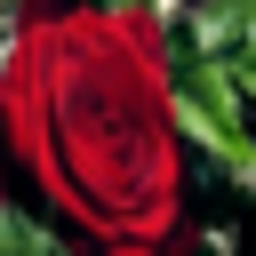

In [333]:
with open('cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open('cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# Здесь указать ваши классы по варианту!!!
CLASSES = [19, 70, 35]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
print(train_X)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCHW -> NHWC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[12]).resize((256,256))

In [334]:
batch_size = 100
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)], ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64), num_classes=len(CLASSES))/1.
    dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader
len(dataloader["train"])

15

In [335]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return torch.flatten(x, start_dim=1) # nhwc -> nm

class Cifar100_MLP(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_MLP, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025])
        self.seq = nn.Sequential(
            nn.Linear(32*32*3, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, classes),
        )

    def forward(self, input):
        x = self.norm(input)
        return self.seq(x)

HIDDEN_SIZE = 10
model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [336]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [337]:
dataloader['train']

In [338]:
EPOCHS = 291
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
minValLoss = 1
epochGood = 0
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    running_loss = 0.0
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps_per_epoch:.3f}')
    running_loss = 0.0
    model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    if running_loss / steps_per_epoch_val < minValLoss:
        epochGood = epoch
    minValLoss = min(running_loss / steps_per_epoch_val, minValLoss)
    print(f'[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}')
print('Обучение закончено')

[1,    15] loss: 1.101
[1,     3] val loss: 1.098


[2,    15] loss: 1.089
[2,     3] val loss: 1.089
[3,    15] loss: 1.081
[3,     3] val loss: 1.082
[4,    15] loss: 1.075
[4,     3] val loss: 1.075
[5,    15] loss: 1.068
[5,     3] val loss: 1.069
[6,    15] loss: 1.062
[6,     3] val loss: 1.062
[7,    15] loss: 1.056
[7,     3] val loss: 1.056
[8,    15] loss: 1.050
[8,     3] val loss: 1.051
[9,    15] loss: 1.044
[9,     3] val loss: 1.045
[10,    15] loss: 1.038
[10,     3] val loss: 1.039
[11,    15] loss: 1.032
[11,     3] val loss: 1.033
[12,    15] loss: 1.026
[12,     3] val loss: 1.027
[13,    15] loss: 1.020
[13,     3] val loss: 1.022
[14,    15] loss: 1.014
[14,     3] val loss: 1.016
[15,    15] loss: 1.008
[15,     3] val loss: 1.010
[16,    15] loss: 1.002
[16,     3] val loss: 1.005
[17,    15] loss: 0.996
[17,     3] val loss: 0.999
[18,    15] loss: 0.991
[18,     3] val loss: 0.993
[19,    15] loss: 0.985
[19,     3] val loss: 0.987
[20,    15] loss: 0.979
[20,     3] val loss: 0.981
[21,    15] loss: 0.973
[21,

In [339]:
epochGood

220

In [340]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data

            outputs = model(inputs).detach().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

train
              precision    recall  f1-score   support

          19     0.8677    0.8660    0.8669       500
          70     0.8513    0.8700    0.8605       500
          35     0.8939    0.8760    0.8848       500

    accuracy                         0.8707      1500
   macro avg     0.8710    0.8707    0.8707      1500
weighted avg     0.8710    0.8707    0.8707      1500

--------------------------------------------------
test
              precision    recall  f1-score   support

          19     0.8434    0.7000    0.7650       100
          70     0.6847    0.7600    0.7204       100
          35     0.8019    0.8500    0.8252       100

    accuracy                         0.7700       300
   macro avg     0.7766    0.7700    0.7702       300
weighted avg     0.7766    0.7700    0.7702       300

--------------------------------------------------


(10, 3072)


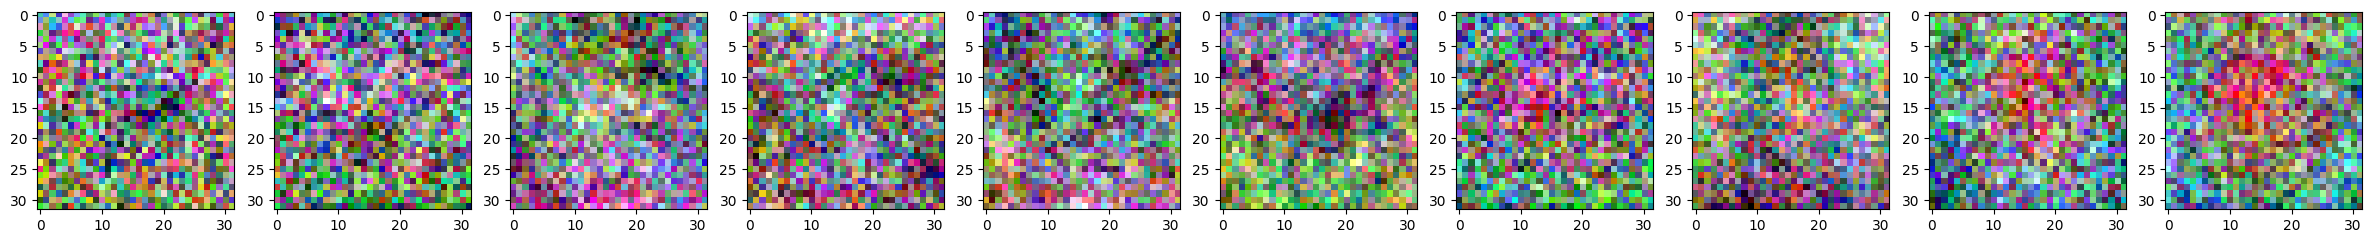

In [341]:
weights = list(model.parameters())[0].detach().numpy()
print(weights.shape)
fig, ax = plt.subplots(1, weights.shape[0], figsize=(3*weights.shape[0], 3))
for i, ω in enumerate(weights):
    ω = ω.reshape(32, 32, 3)
    ω -= np.percentile(ω, 1, axis=[0, 1])
    ω /= np.percentile(ω, 99, axis=[0, 1])
    ω = np.clip(ω, 0, 1) 
    ax[i].imshow(ω)